In [1]:
from segment_anything import SamPredictor, sam_model_registry,SamAutomaticMaskGenerator

In [2]:


import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [3]:

img = cv2.imread("shawarma.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


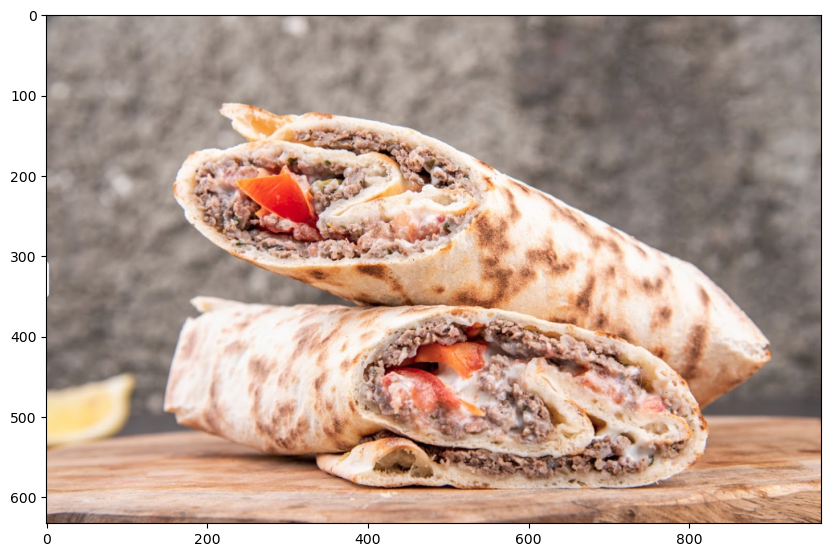

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('on')
plt.show()

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

predictor = SamPredictor(sam)

In [6]:
predictor.set_image(img)


In [17]:
input_point = np.array([[450,230]])
input_label = np.array([1])

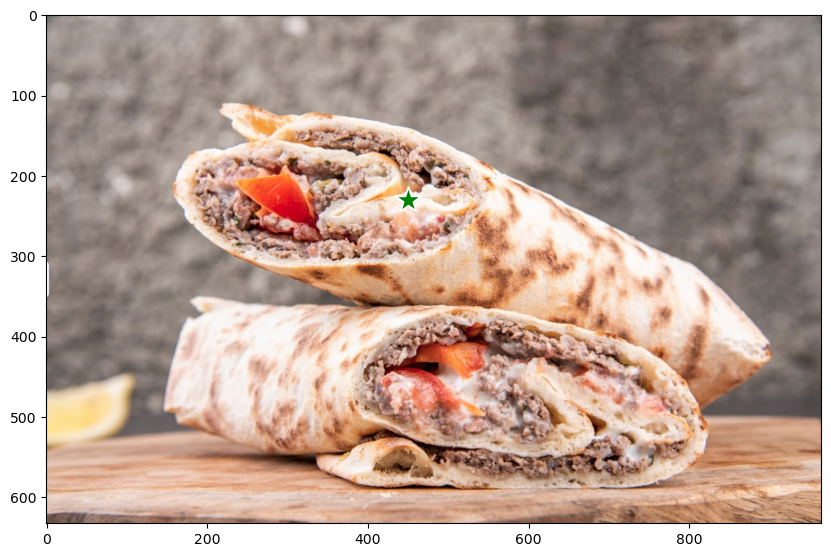

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [19]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)


In [20]:
print(img.shape)
print(masks.shape)

(633, 965, 3)
(3, 633, 965)


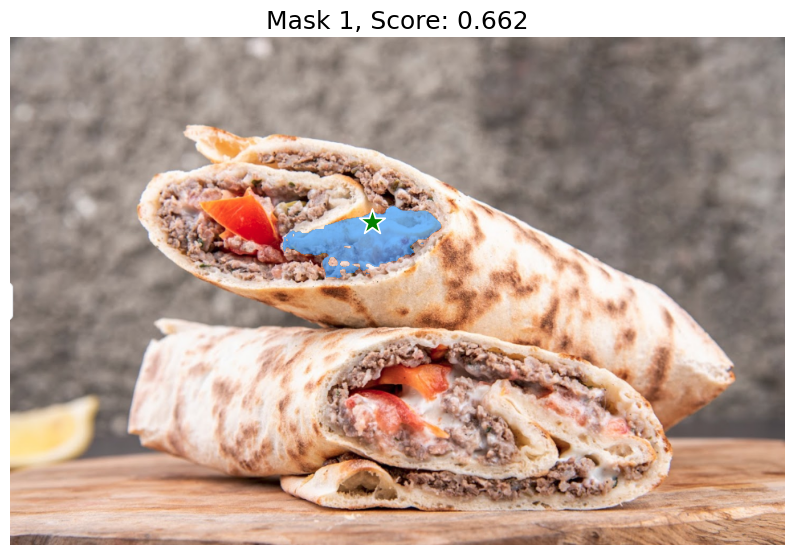

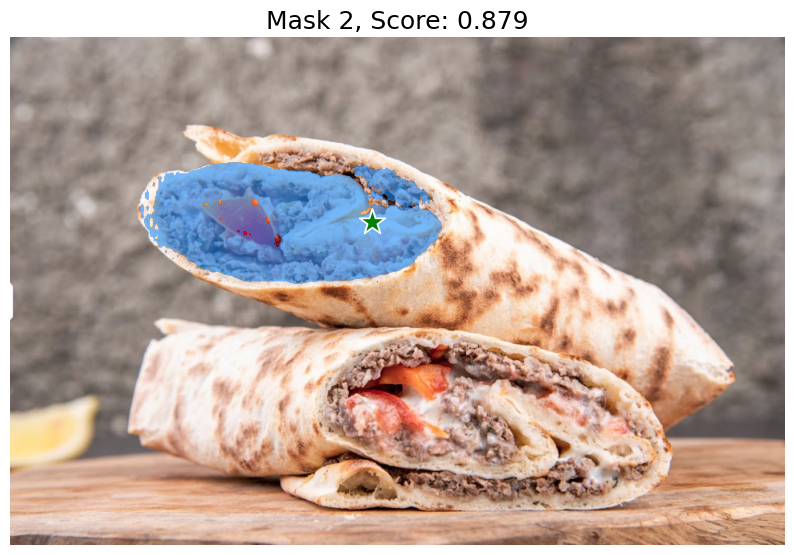

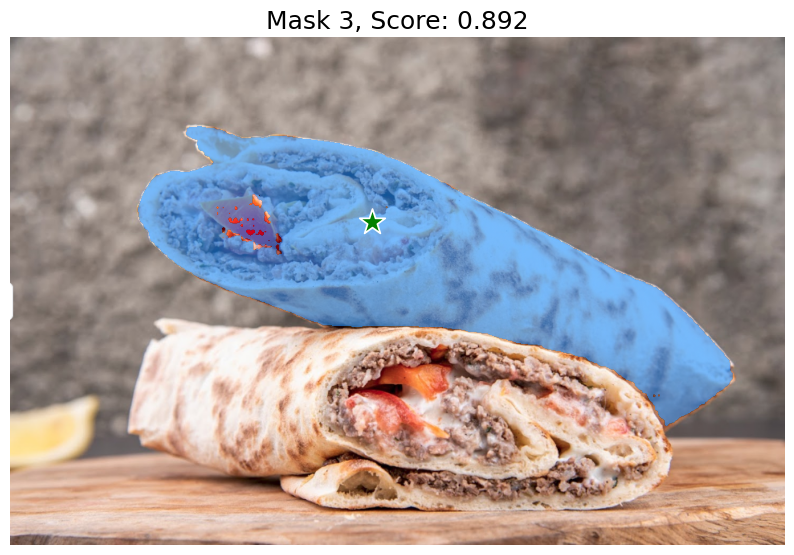

In [21]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Your existing code for generating and highlighting masks
# ...

# Function to resize the mask
def resize_mask(mask, new_size=(256, 256)):
    mask_img = Image.fromarray((mask * 255).astype(np.uint8))
    resized_mask = mask_img.resize(new_size)
    plt.imshow(resized_mask)
    return np.array(resized_mask) / 255

resize_mask()
# Function to overlay the mask onto a white background


ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

In [ ]:

def overlay_mask_on_white_bg(img, mask, img_size=(256, 256)):
    # Create a white background image
    white_bg = Image.new('RGBA', img_size, (255, 255, 255, 255))

    # Resize the mask and convert it to a boolean array
    resized_mask = resize_mask(mask).astype(bool)

    # Resize the input image
    img_resized = img.resize(img_size)

    # Create a blank image with the same size as the input image
    masked_img = Image.new('RGBA', img_size)

    # Paste the input image onto the blank image using the resized mask as a mask
    masked_img.paste(img_resized, (0, 0), Image.fromarray((resized_mask * 255).astype(np.uint8)))

    # Paste the masked image onto the white background
    white_bg.paste(masked_img, (0, 0), masked_img)

    return white_bg.convert('RGB')

# Iterate over the masks and create separate images
for i, (mask, score) in enumerate(zip(masks, scores)):
    # Overlay the resized mask onto the white background
    masked_img = overlay_mask_on_white_bg(img, mask)
    
    # Save the masked image to a file
    masked_img.save(f"mask_{i + 1}.png")


In [54]:
print(masks[0])

IndexError: index 500 is out of bounds for axis 0 with size 3

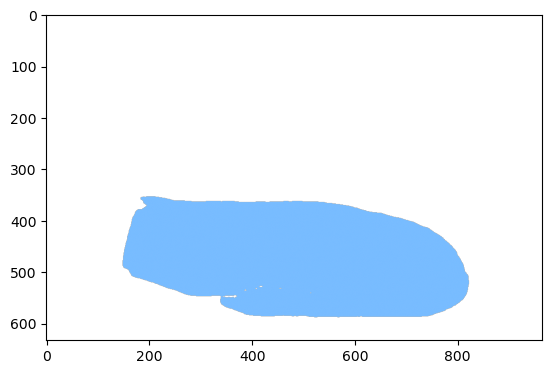

In [59]:
mask = masks[2]
h, w = mask.shape[-2:]
color = np.array([30/255, 144/255, 255/255, 0.6])
mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
plt.imshow(mask_image)

In [71]:
import numpy as np

def apply_mask_on_image(img, mask):
    # Ensure the mask is a boolean array
    mask = mask.astype(bool)

    # Create a white image with the same shape as the input image
    white_bg = np.full(img.shape, 255, dtype=np.uint8)

    # Apply the mask to the input image by combining the masked area with the white background
    masked_img = np.where(mask[..., np.newaxis], img, white_bg)

    return masked_img
def resize_image_aspect_ratio(img_np, max_size=(256, 256)):
    img = Image.fromarray(img_np)
    img.thumbnail(max_size)
    return np.array(img)
def resize_image(img_np, new_size=(256, 256)):
    img = Image.fromarray(img_np)
    img_resized = img.resize(new_size)
    return np.array(img_resized)

(168, 256, 3)


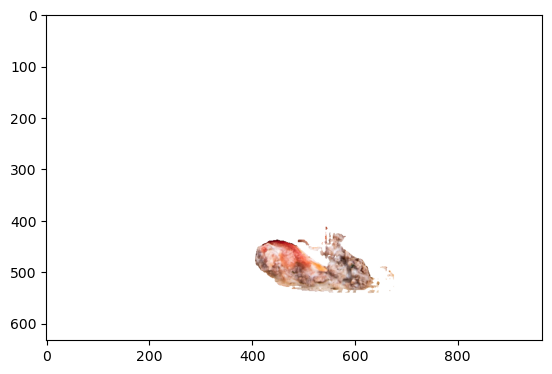

(168, 256, 3)


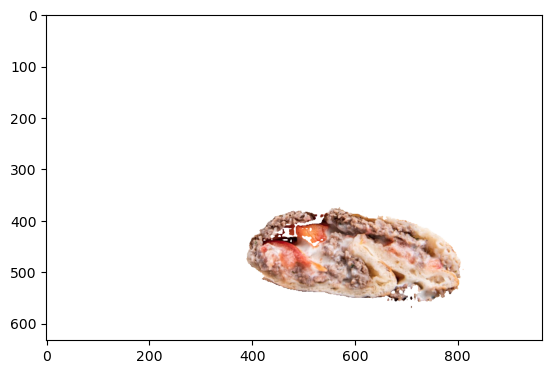

(168, 256, 3)


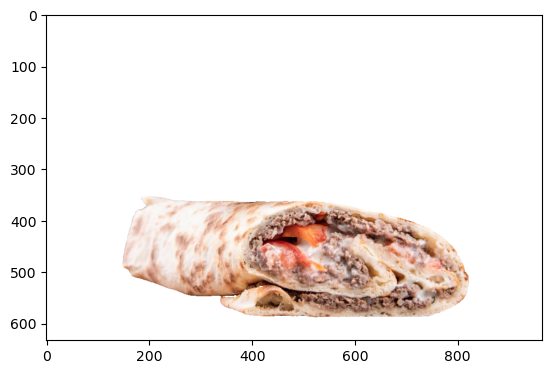

In [73]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    masked_img = apply_mask_on_image(img, mask)
    resized_masked_img = resize_image_aspect_ratio(masked_img, max_size=(256, 256))
    print(resized_masked_img.shape)
    plt.imsave(f"masked_image_{i + 1}.png", resized_masked_img)
    plt.imshow(masked_img)
    plt.show()


In [7]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [8]:
mask_generator = SamAutomaticMaskGenerator(sam)


In [22]:
new_masks = mask_generator.generate(img)


In [23]:
print(len(new_masks))
print(new_masks[0].keys())

35
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


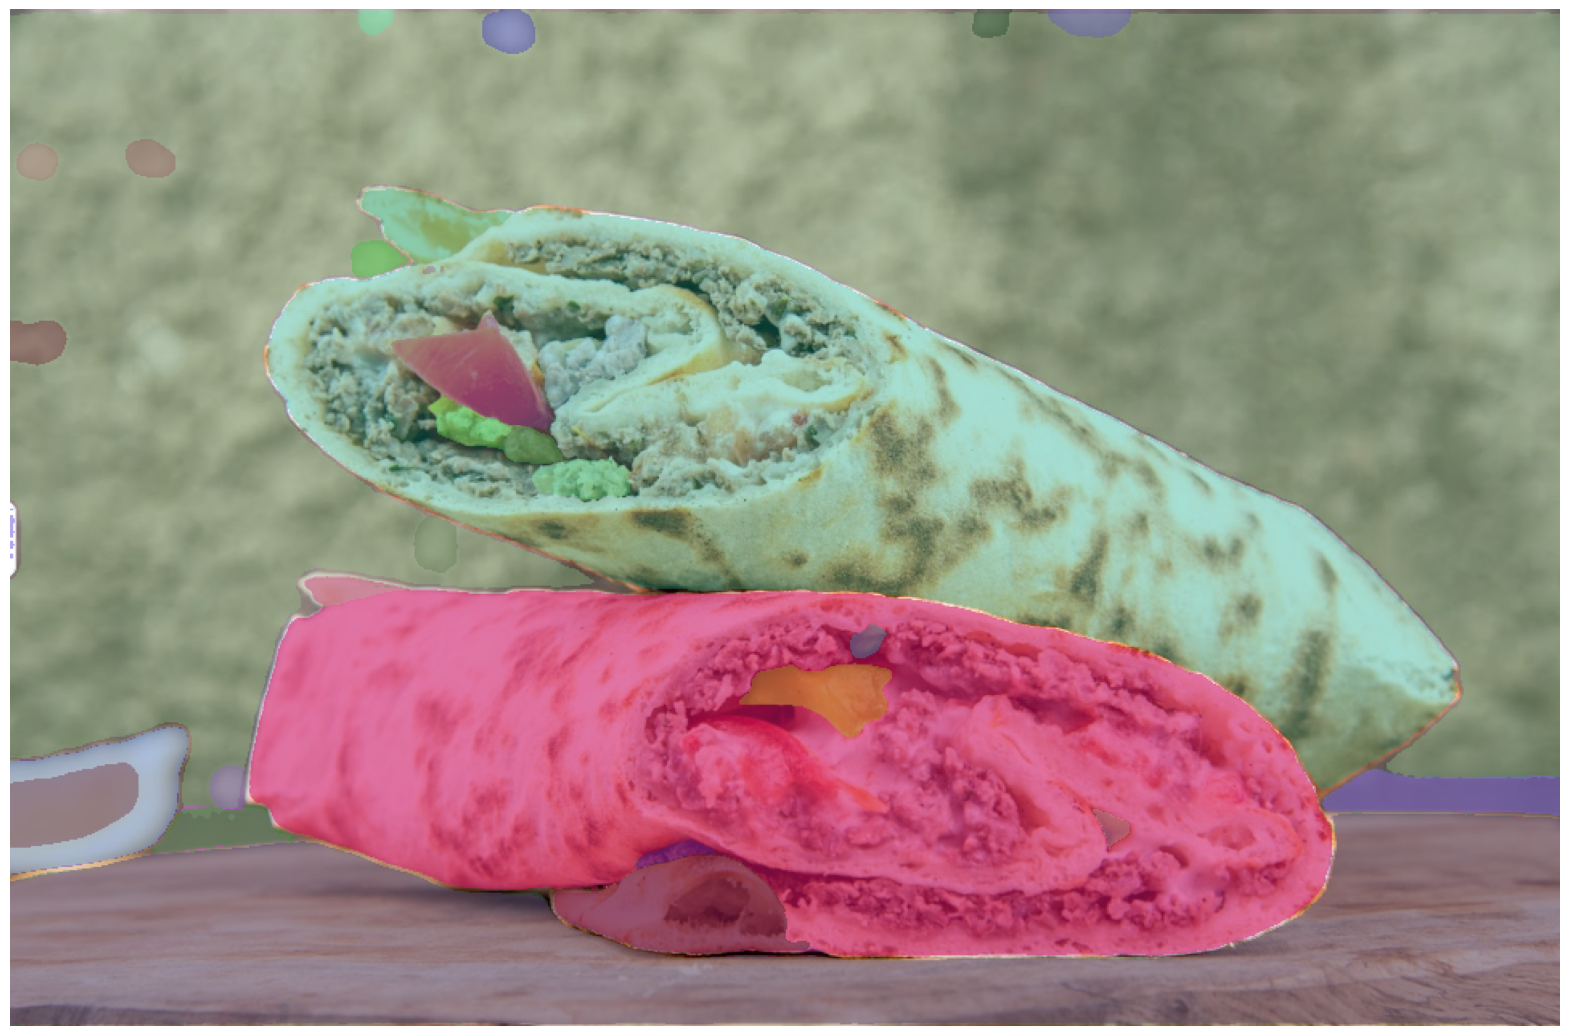

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(new_masks)
plt.axis('off')
plt.show() 


In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from PIL import Image

# Load the pre-trained ResNet-50 model
model = ResNet50(weights='imagenet')

# Load the generated image
image_file = "masked_image_3.png"  # Replace this with the file name of your generated image
image = Image.open(image_file)

# Resize and preprocess the image
image = image.convert('RGB')
image = image.resize((224, 224))  # ResNet-50 expects input images to be 224x224
image_np = np.array(image)
image_np = preprocess_input(image_np)
image_np = np.expand_dims(image_np, axis=0)

# Make a prediction
predictions = model.predict(image_np)

# Decode and print the predictions
decoded_predictions = decode_predictions(predictions, top=3)[0]
print("Top 3 predictions:")
for i, (class_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}. {label} ({score:.2f})")


35363/35363 [==============================] - 0s 1us/step
Top 3 predictions:
1. red_wine (0.05)
2. shower_cap (0.04)
3. studio_couch (0.04)
